In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.models.llama.modeling_llama import LlamaModel, LlamaForCausalLM
import torch
from torch import nn
from typing import Optional, Dict, Any, List, Union
from user_seq_modeling.hllm import EventEncoder, GenerativeInfoNCELoss

In [2]:
model_path = '/Users/zhouzhipeng/llm_models/TinyLlama-1.1B-3T'
encoder = EventEncoder(model_path)

In [3]:
events_1 = [
    "用户在借呗申请支用了 100 元，还款方式选择先息后本",
    "用户在花呗提前还款了 200 元",
    "用户在借呗申请支用了 300 元，还款方式选择等额本息",
    "用户在借呗到期还款了 400 元"
]
events_2 = [
    "用户在借呗申请支用了 100 元，还款方式选择先息后本",
    "用户在花呗提前还款了 200 元",
    "用户在借呗申请支用了 300 元，还款方式选择等额本息",
    "用户在借呗到期还款了 400 元",
    "用户在网商银行贷款申请支用 500 元",
    "用户在备用金申请支用了 600 元，还款方式选择等额本息"
]

In [4]:
hidden_states, attention_mask = encoder([events_1, events_2])

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [5]:
attention_mask

tensor([[0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='mps:0')

In [6]:
user_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
user_model.dtype, user_model.device

(torch.bfloat16, device(type='mps', index=0))

In [13]:
outputs = user_model.base_model(
    inputs_embeds=hidden_states,
    attention_mask=attention_mask,
    use_cache=False,
)

In [20]:
event_embeddings = hidden_states
encoder_outputs = outputs.last_hidden_state
event_embeddings.shape, encoder_outputs.shape

(torch.Size([2, 6, 2048]), torch.Size([2, 6, 2048]))

In [26]:
from torch.nn import functional as F

In [49]:
cur_embs = torch.randn(size=(2, 32, 128))
target_pos = torch.randn(size=(2, 32, 128))
output_embs = cur_embs / cur_embs.norm(dim=-1, keepdim=True)
target_pos_embs = target_pos / target_pos.norm(dim=-1, keepdim=True)
pos_logits = F.cosine_similarity(output_embs, target_pos_embs, dim=-1).unsqueeze(-1)
pos_logits.shape

torch.Size([2, 32, 1])

In [50]:
neg_embedding_all = torch.randn(size=(64, 128)) # [num, dim]
neg_embedding_all = neg_embedding_all.transpose(-1, -2)
neg_logits = torch.matmul(output_embs, neg_embedding_all)
fix_logits = torch.matmul(target_pos_embs, neg_embedding_all)
neg_logits[fix_logits > 0.99] = torch.finfo(neg_logits.dtype).min
logits = torch.cat([pos_logits, neg_logits], dim=-1)
user_attention_mask = torch.ones(size=(2, 32), dtype=torch.long)
logits = logits[user_attention_mask.bool()] * 1
labels = torch.zeros(logits.size(0), device=logits.device, dtype=torch.int64)
# neg_logits[fix_logits > self.nce_thres] = torch.finfo(neg_logits.dtype).min

In [51]:
logits.shape, labels.shape

(torch.Size([64, 65]), torch.Size([64]))

In [52]:
user_attention_mask.bool()

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])

In [37]:
torch.finfo(neg_logits.dtype).min

-3.4028234663852886e+38

In [54]:
cu_input_lens = torch.tensor([
    [4, 6, 9],
    [2, 4, 5]
])

In [56]:
cu_input_lens.cumsum(dim=0)

tensor([[ 4,  6,  9],
        [ 6, 10, 14]])

In [ ]:
cu_input_lens

In [21]:
loss_func = GenerativeInfoNCELoss(temperature=1.0)

In [22]:
encoder_outputs = torch.randn(size=(16, 32, 128))
event_embeddings = torch.randn(size=(16, 32, 128))
loss_func(encoder_outputs, event_embeddings)

tensor(18.3851, grad_fn=<NllLossBackward0>)

In [25]:
torch.finfo(torch.bfloat16).min, torch.finfo(torch.float32).max

(-3.3895313892515355e+38, 3.4028234663852886e+38)

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.add_tokens('[EVENT]', special_tokens=True)
tokenizer.padding_side = "left"

In [33]:
text = "用户在借呗支用申请了 1000 元"
text = "1 + 1 = "
inputs = tokenizer(
    [text], return_tensors="pt",
    padding='max_length', max_length=32
).to(user_model.device)
inputs

{'input_ids': tensor([[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000,     1, 29871, 29896,   718, 29871, 29896,
           353, 29871]], device='mps:0'), 'attention_mask': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}

In [9]:
output_ids = model.generate(**inputs, max_new_tokens=64)
tokenizer.decode(output_ids[0], skip_special_tokens=True)

'1 + 1 = 2\n\n    # 1 + 1 = 2\n    # 1 + 2 = 3\n    # 2 + 3 = 5\n    # 3 + 5 = 8\n    # 5 + 8 = 13\n    # 13'

In [8]:
model.get_output_embeddings().weight.shape

torch.Size([32000, 2048])

In [9]:
model.get_input_embeddings().weight.shape

torch.Size([32000, 2048])

In [11]:
model.model.layers

ModuleList(
  (0-21): 22 x LlamaDecoderLayer(
    (self_attn): LlamaSdpaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=256, bias=False)
      (v_proj): Linear(in_features=2048, out_features=256, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
      (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
      (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [13]:
model.model.embed_tokens

Embedding(32000, 2048)

In [93]:
embed = model.model.embed_tokens(inputs['input_ids'])
embed.shape

torch.Size([1, 32, 2048])

In [95]:
model.model.rotary_emb

LlamaRotaryEmbedding()

In [115]:
decoder_outputs = model.model(inputs_embeds=embed, attention_mask=inputs['attention_mask'])

In [120]:
decoder_outputs['last_hidden_state'][0:10]

tensor([[[ 0.6968,  1.4873,  3.3672,  ...,  2.0156,  2.9414, -0.3071],
         [ 1.1699,  1.9434,  3.5449,  ...,  1.9336,  1.8779,  0.1746],
         [ 1.7412,  2.2168,  1.3965,  ...,  1.3164,  2.8262, -0.3462],
         ...,
         [-0.6997,  1.9951,  0.5986,  ...,  0.0276,  2.1426, -0.1182],
         [-1.3799,  0.8369, -0.3835,  ...,  1.2031,  2.2344, -1.3838],
         [-1.1445,  1.5146,  0.8105,  ...,  0.1543,  1.5947, -0.6475]]],
       device='mps:0', dtype=torch.float16, grad_fn=<SliceBackward0>)

In [121]:
model.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask']).last_hidden_state[0:10]

tensor([[[ 0.6968,  1.4873,  3.3672,  ...,  2.0156,  2.9414, -0.3071],
         [ 1.1699,  1.9434,  3.5449,  ...,  1.9336,  1.8779,  0.1746],
         [ 1.7412,  2.2168,  1.3965,  ...,  1.3164,  2.8262, -0.3462],
         ...,
         [-0.6997,  1.9951,  0.5986,  ...,  0.0276,  2.1426, -0.1182],
         [-1.3799,  0.8369, -0.3835,  ...,  1.2031,  2.2344, -1.3838],
         [-1.1445,  1.5146,  0.8105,  ...,  0.1543,  1.5947, -0.6475]]],
       device='mps:0', dtype=torch.float16, grad_fn=<SliceBackward0>)

In [146]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor

In [26]:
seq_cuts = np.linspace(0, 1, 101)
seq_lens = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3.615070280198076, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 12, 12, 13, 14, 16, 17, 19, 22, 26, 37, 45869]

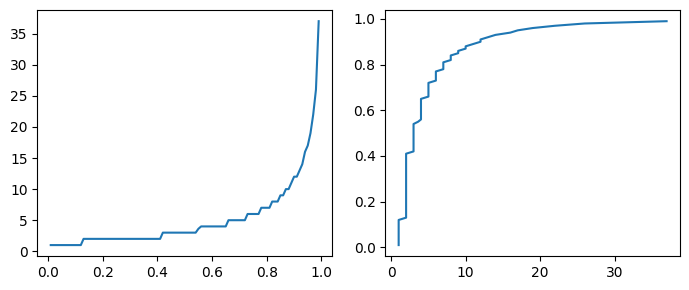

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# seq_lens vs seq_cuts
ax[0].plot(seq_cuts[1:-1], seq_lens[1:-1])
# seq_cuts vs seq_lens
ax[1].plot(seq_lens[1:-1], seq_cuts[1:-1])
plt.tight_layout()

In [151]:
x = np.random.uniform(low=-3, high=3, size=(1000,))
# h-sigma model, sigma(x) = 1 + exp(-|x|)
# logit model, logit = (x + 1) * x * (x - 1)
sigma = 0.2 + np.exp(np.abs(1*x))
noise = np.random.normal(loc=0, scale=sigma, size=(1000,))
y = (x + 2) * x * (x - 1) + noise
x_concat = np.concatenate([x.reshape(-1, 1), x.reshape(-1, 1)**2, x.reshape(-1, 1)**3], axis=1)

In [156]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(x.reshape(-1, 1), y)
lower = QuantileRegressor(quantile=0.05, alpha=0).fit(x_concat, y)
upper = QuantileRegressor(quantile=0.95, alpha=0).fit(x_concat, y)
y_pred = model.predict(x.reshape(-1, 1))
y_lower = lower.predict(x_concat)
y_upper = upper.predict(x_concat)
err = y - y_pred

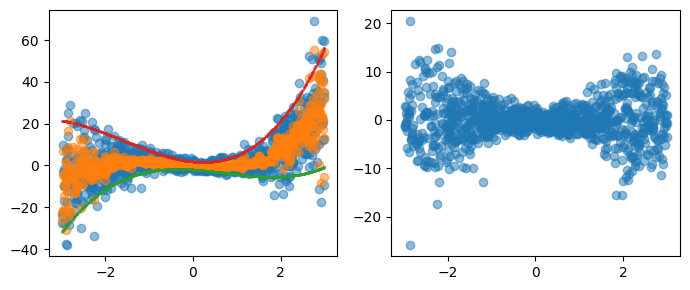

In [161]:
fig, ax = plt.subplots(1,2,figsize=(7, 3))
ax[0].scatter(x, y, alpha=0.5)
ax[0].scatter(x, y_pred, alpha=0.5)
ax[0].scatter(x, y_lower, alpha=0.5, s=1)
ax[0].scatter(x, y_upper, alpha=0.5, s=1)
ax[1].scatter(x, err, alpha=0.5)
plt.tight_layout()